## **서울시 작은도서관 데이터 분석**

### **데이터 불러오기**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [3]:
# 엑셀 불러오기
data = pd.read_excel('/content/drive/MyDrive/Contest/Library/Dataset/도서관_현황정보.xlsx')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   도서관명                   954 non-null    object 
 1   분관여부                   954 non-null    object 
 2   도서관 유형                 954 non-null    int64  
 3   일평균                    954 non-null    int64  
 4   연간 총 운영일               954 non-null    int64  
 5   건물면적(㎡)                954 non-null    float64
 6   열람(석)                  954 non-null    int64  
 7   현재 총 보유장서의 수(권)        954 non-null    int64  
 8   현재 총 보유 연속간행물의 수(종)    954 non-null    int64  
 9   운영위원회
구성유무             954 non-null    object 
 10  정기모임 횟수                954 non-null    int64  
 11  PC현황 유무                954 non-null    object 
 12  상근직원(명)                954 non-null    int64  
 13  시간제직원(명)               954 non-null    int64  
 14  정기적자원봉사자(명)            954 non-null    int64  
 15  비정기적자원

### **데이터 전처리**

In [5]:
# 중복 컬럼인 주소 삭제
data.drop('주소', axis=1, inplace=True)
# 중복 행 지우기
data.drop_duplicates(inplace=True)

In [6]:
data.columns

Index(['도서관명', '분관여부', '도서관 유형', '일평균', '연간 총 운영일', '건물면적(㎡)', '열람(석)',
       '현재 총 보유장서의 수(권)', '현재 총 보유 연속간행물의 수(종)', '운영위원회\n구성유무', '정기모임 횟수',
       'PC현황 유무', '상근직원(명)', '시간제직원(명)', '정기적자원봉사자(명)', '비정기적자원봉사자(명)',
       '사서자격증보유자', '직원 교육시간(시간)', '재정자립도', '예산합계(원)', '도서관외대출여부', '연간도서대출권수',
       '연간 총 이용자수(명)', '등록된 \n총 이용자수\n(회원등록자 수)', '상호대차서비스 제공유무',
       '독서/문화프로그램 실시여부', '운영상태', '경도', '위도', '지번주소'],
      dtype='object')

In [7]:
# 컬럼명 변경
data.columns = ['Name','Branch', 'Type', 'Operating_hours', 'Operating_days', 'Area', 'Room', 'Books', 'Publications', 'Committee', 'Meeting', 'PC', 'Full_time', 'Part_time', 'Regular_volunteer', 'Irregular_volunteer',
                'License', 'Training_time', 'Financial', 'Budget', 'Off_library', 'Borrow', 'Target', 'Registration', 'Mutual_borrow', 'Program', 'Operation_status', 'Longitude', 'Latitude', 'Address']

#### 주소 데이터 이용하여 변수 추출

In [8]:
# 주소 데이터 접근, iterrows 사용가능
for index, row in data.iterrows():
  address = str(data.loc[index, 'Address'])
  data.loc[index, 'Gu'] = address.split(sep=' ')[1]

for index, row in data.iterrows():
  address = str(data.loc[index, 'Address'])
  data.loc[index, 'Dong'] = address.split(sep=' ')[2]

In [9]:
data[['Gu', 'Dong']].head(5)

,Gu,Dong
0,종로구,평동
1,종로구,평창동
2,종로구,무악동
3,종로구,숭인동
4,종로구,창신동


#### 파생변수를 이용하여 병합

In [10]:
seoul_class = pd.read_excel('/content/drive/MyDrive/Contest/Library/Dataset/서울시 학급 수.xlsx')
seoul_population = pd.read_excel('/content/drive/MyDrive/Contest/Library/Dataset/서울시 구별 인구수.xlsx')

In [11]:
data_merge = data.merge(seoul_class, on='Gu', how='left')
data_merge = data_merge.merge(seoul_population, on='Gu', how='left')
# 중복 행 지우기
data_merge.drop_duplicates(inplace=True)

In [12]:
data_merge.head()

,Name,Branch,Type,Operating_hours,Operating_days,Area,Room,Books,Publications,Committee,...,0~9,10,20,30,40,50,60,70,80,90+
0,경희궁자이3단지 작은도서관,N,2,8,365,65.60,28,2556,0,N,...,7288,10941,27136,20882,22019,25935,20724,11712,6167,985
2,꿈꾸는 평창동 작은도서관,N,1,8,127,38.50,13,4654,7,Y,...,7288,10941,27136,20882,22019,25935,20724,11712,6167,985
4,나무와 열매 어린이 도서관,N,2,8,200,132.00,25,5820,1,Y,...,7288,10941,27136,20882,22019,25935,20724,11712,6167,985
6,도담도담한옥도서관,N,1,9,232,107.87,30,5615,3,N,...,7288,10941,27136,20882,22019,25935,20724,11712,6167,985
8,두산아파트 새마을문고,N,2,2,144,169.80,25,3100,0,Y,...,7288,10941,27136,20882,22019,25935,20724,11712,6167,985


### **시각화**

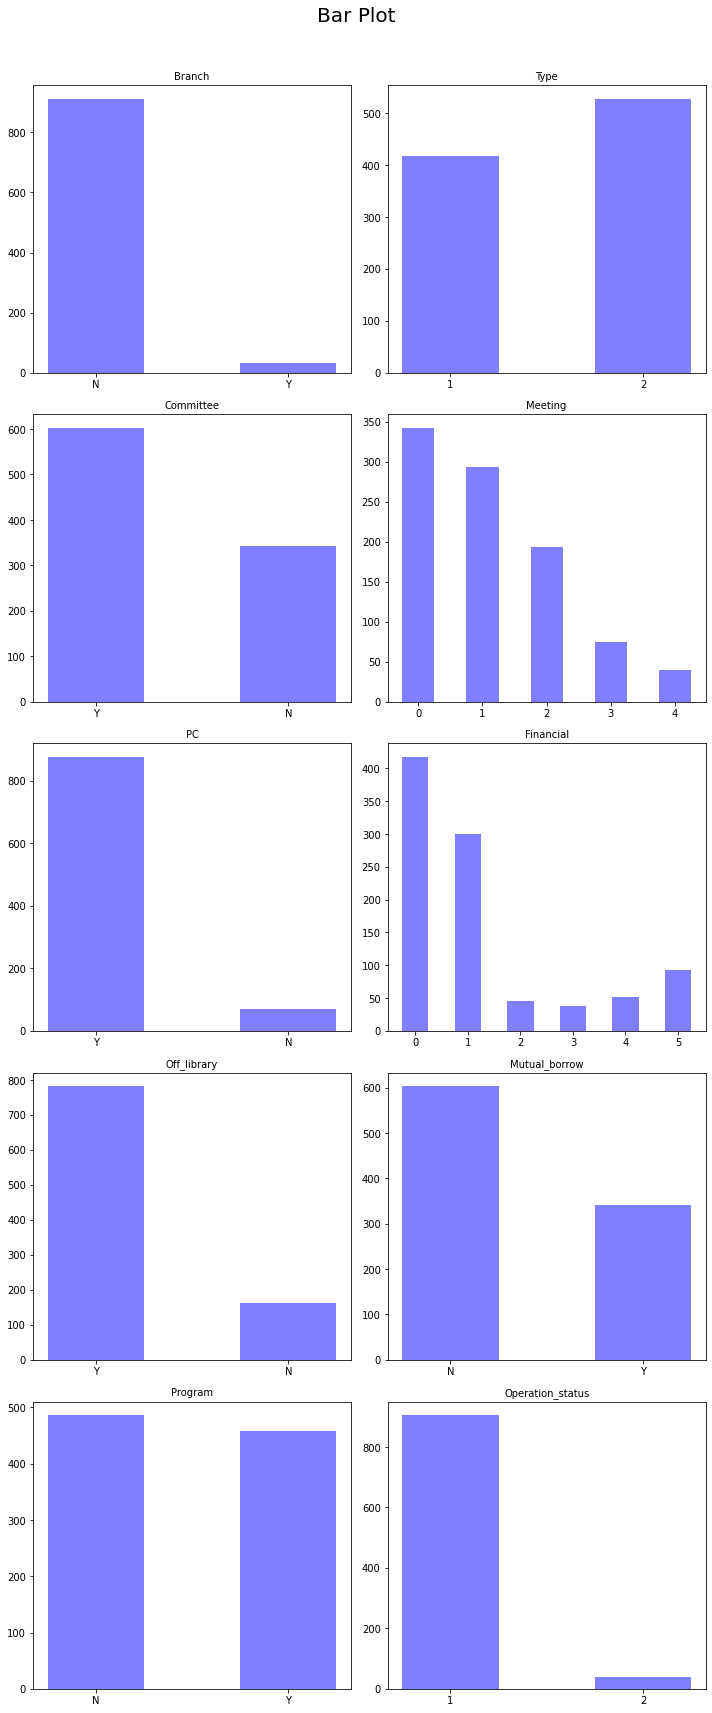

In [13]:
# 범주형 변수 시각화
cate_col = ['Branch', 'Type', 'Committee', 'Meeting', 'PC', 'Financial','Off_library', 'Mutual_borrow', 'Program', 'Operation_status']

plt.figure(figsize=(10,25))
plt.suptitle("Bar Plot", fontsize=20)

for i in range(len(cate_col)):
    plt.subplot(5, 2, i+1)
    plt.title(cate_col[i], fontsize=10)
    temp = data[cate_col[i]].value_counts()
    plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
    plt.xticks(temp.keys(), fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


column name: Operating_hours
column name: Operating_days


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

column name: Area
column name: Room


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

column name: Books
column name: Publications


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

column name: Full_time
column name: Part_time
column name: Regular_volunteer


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

column name: Irregular_volunteer
column name: License
column name: Training_time
column name: Budget


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

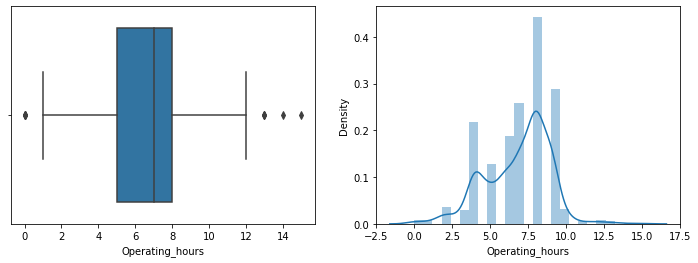

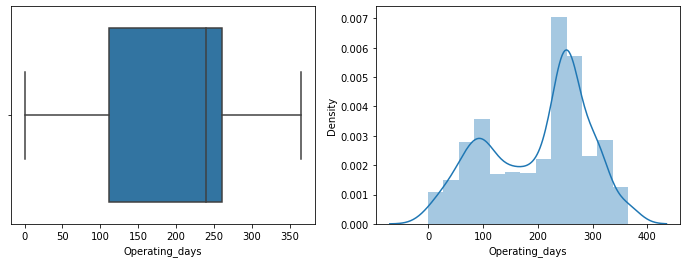

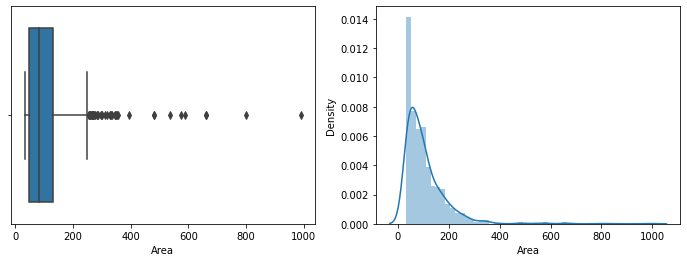

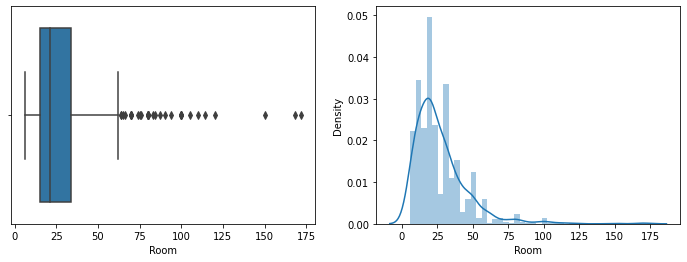

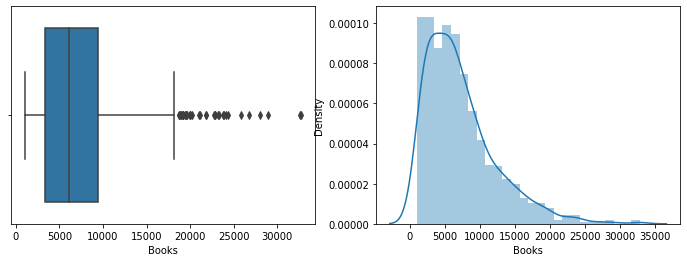

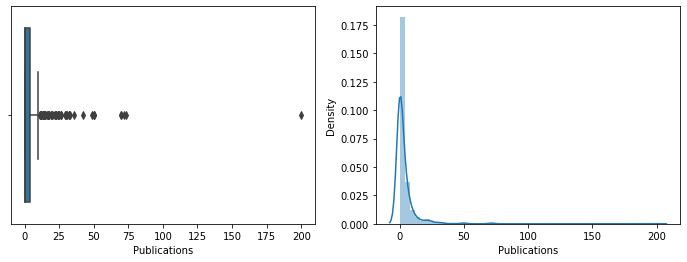

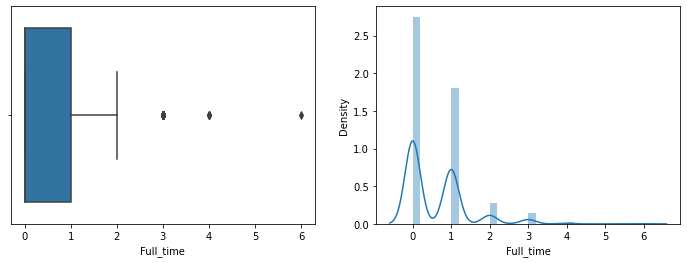

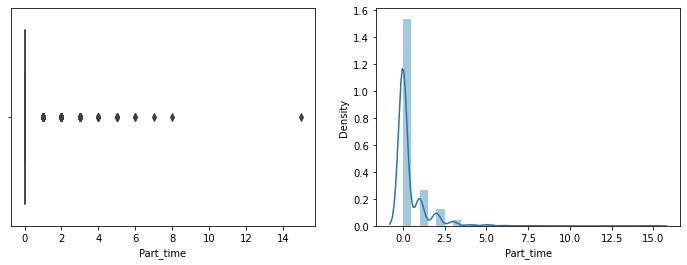

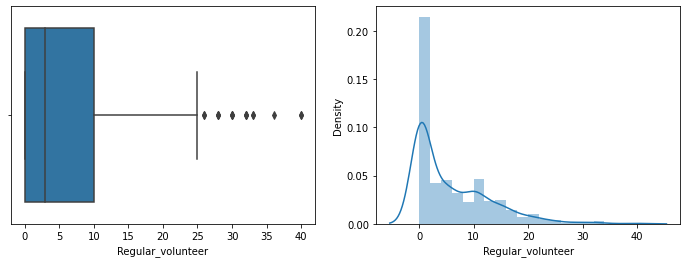

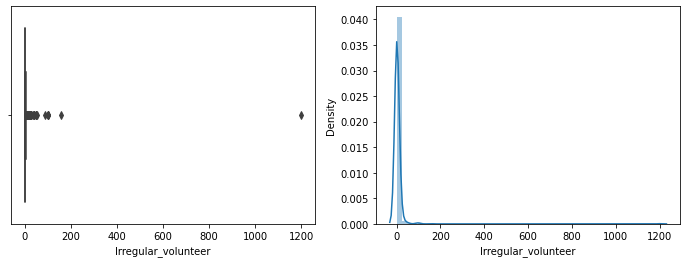

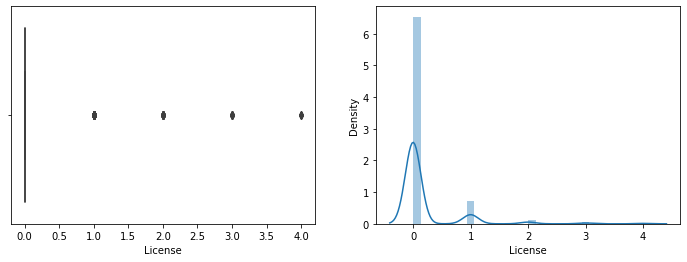

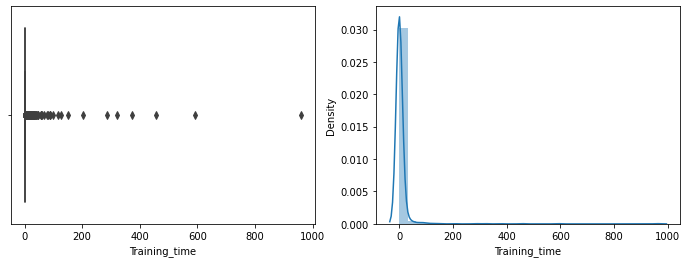

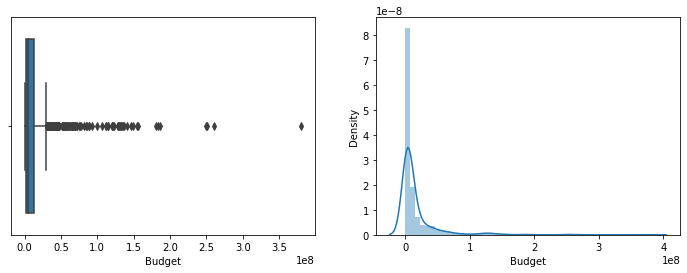

In [14]:
# 수치형 변수 시각화
def show_hist(df, columns):
    for column in columns:
        print('column name:', column)
        fig, axs = plt.subplots(figsize=(12,4), nrows=1, ncols=2 ,squeeze=False)
        sns.boxplot(df[column], ax=axs[0][0])
        sns.distplot(df[column], ax=axs[0][1])

numeric_col = ['Operating_hours', 'Operating_days', 'Area', 'Room', 'Books', 'Publications', 'Full_time', 'Part_time', 'Regular_volunteer', 'Irregular_volunteer', 'License', 'Training_time', 'Budget']
show_hist(data_merge, numeric_col)

#### 기초분석




In [38]:
# 평균치 확인
data_merge.describe().loc['mean',['Books', 'Area']]


Type                         2
Operating_hours              7
Operating_days             200
Area                       105
Room                        27
Books                     7222
Publications                 4
Full_time                    1
Part_time                    0
Regular_volunteer            6
Irregular_volunteer          2
License                      0
Training_time                0
Financial                    1
Budget                15396941
Borrow                    2353
Target                    2815
Registration              2131
Operation_status             1
Longitude                  127
Latitude                    38
Kindergarten_class         160
Elementary_class           797
Middle_class               369
High_class                 389
0~9                      25837
10                       33159
20                       62739
30                       63602
40                       65132
50                       66438
60                       56013
70      

In [16]:
# 이상치 제거
def cut_outlier(df, columns):
    df=df.copy()
    for column in columns:
        q1=df[column].quantile(.25)
        q3=df[column].quantile(.75)
        iqr=q3-q1
        low=q1-1.5*iqr
        high=q3+1.5*iqr
        df.loc[df[column]<low, column]=low
        df.loc[df[column]>high, column]=high
    return df

data_merge = cut_outlier(data_merge,['Training_time', 'License', 'Irregular_volunteer'])

#### Forium 시각화

In [17]:
import requests
import json
from folium.plugins import MarkerCluster

# 서울 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

m = folium.Map(
    location=[37.559819, 126.963895],
    zoom_start=11, 
    tiles='cartodbpositron'
)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

marker_cluster = MarkerCluster().add_to(m)

for lat, long in zip(data_merge['Latitude'], data_merge['Longitude']):
    folium.Marker([lat, long], icon = folium.Icon(color="green")).add_to(marker_cluster)

m

### **모델링 및 분석**

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


data_merge.drop(['Gu','Dong', 'Address', 'Branch', 'Meeting','Committee'], axis=1, inplace=True)

# 범주형 변수 인코딩
ohe_data = pd.get_dummies(data_merge, columns=['Type', 'PC', 'Financial','Off_library', 'Mutual_borrow', 'Program', 'Operation_status'])
# ## 라벨인코더 실행해보기

# 인덱스 설정
ohe_data.set_index('Name', inplace=True)

# 스케일링
scaler = StandardScaler()
scaler.fit(ohe_data[numeric_col])
ohe_data[numeric_col] = scaler.transform(ohe_data[numeric_col])

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor #LGB회귀
from sklearn.ensemble import RandomForestRegressor

y_data = ohe_data['Target']
X_data = ohe_data.drop(['Target','Borrow','Longitude','Latitude'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=2022)

rf_rg = RandomForestRegressor(n_estimators=1000, random_state=2022)
lg_rg = LGBMRegressor(n_estimators=1000, random_state=2022)

rf_rg.fit(X_train, y_train)
lg_rg.fit(X_train, y_train)

rf_pred = rf_rg.predict(X_train)
lg_pred = lg_rg.predict(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Budget                 0.261311
Books                  0.138530
Room                   0.122233
Area                   0.091946
Registration           0.062383
Operating_days         0.058008
Irregular_volunteer    0.030358
Operating_hours        0.024044
Regular_volunteer      0.020035
Financial_2            0.019526
Publications           0.016352
20                     0.013092
Part_time              0.011604
80                     0.009621
High_class             0.009132
90+                    0.008770
Financial_1            0.008276
30                     0.008261
Kindergarten_class     0.006967
60                     0.006732
Mutual_borrow_N        0.006116
50                     0.006083
70                     0.005889
10                     0.005562
Full_time              0.005287
40                     0.005130
Middle_class           0.005056
Mutual_borrow_Y        0.005004
0~9                    0.004659
Elementary_class       0.004311
Program_Y              0.003329
Financia

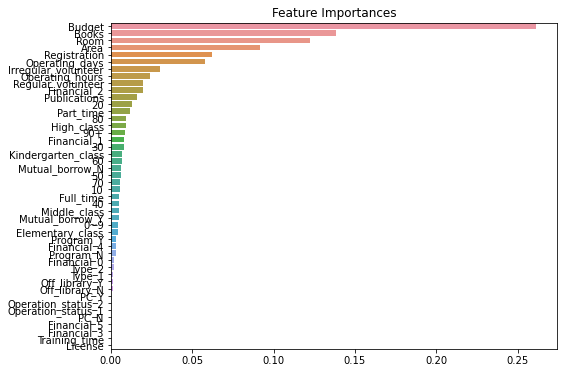

In [20]:
# Feature Importance
ftr_importances = pd.Series(rf_rg.feature_importances_,index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)
print(ftr_top)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

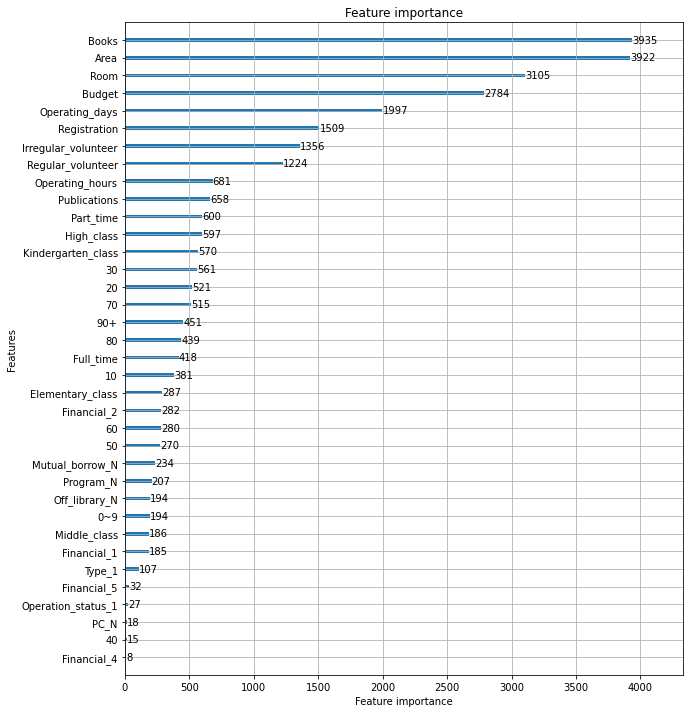

In [21]:
from lightgbm import plot_importance
fig, axs = plt.subplots(figsize=(10,12))
plot_importance(lg_rg,ax=axs)

#### SHAP Value

In [22]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 15.7 MB/s 


In [23]:
explainer = shap.TreeExplainer(lg_rg) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_train) # Shap Values 계산

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

Output hidden; open in https://colab.research.google.com to view.

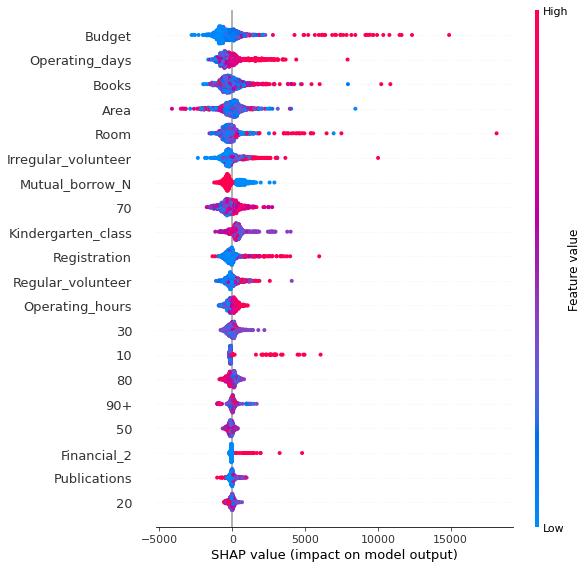

In [25]:
shap.summary_plot(shap_values, X_train)

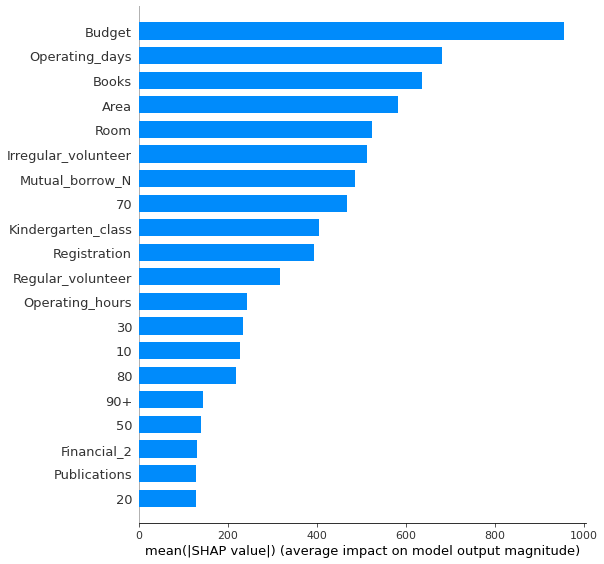

In [26]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

#### 군집분석

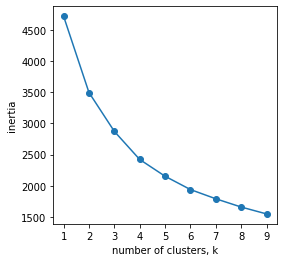

In [27]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)
cl_data = ohe_data[['Budget', 'Books', 'Operating_days', 'Room' ,'Area']]
ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(cl_data)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [32]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, random_state=0)
cluster = model.fit(cl_data)

In [33]:
# 원래 데이터에 예측된 군집 붙이기
clust_df = data_merge[['Name', 'Budget', 'Books', 'Operating_days', 'Room' ,'Area', 'Target']].copy()
clust_df['clust'] = cluster.labels_
clust_df.head()

,Name,Budget,Books,Operating_days,Room,Area,Target,clust
0,경희궁자이3단지 작은도서관,52000,2556,365,28,66,4320,3
2,꿈꾸는 평창동 작은도서관,17937000,4654,127,13,38,446,2
4,나무와 열매 어린이 도서관,12800000,5820,200,25,132,2500,3
6,도담도담한옥도서관,27517000,5615,232,30,108,1267,3
8,두산아파트 새마을문고,500000,3100,144,25,170,573,2


In [37]:
pd.options.display.float_format = '{:.0f}'.format
clust_mean = clust_df.groupby('clust').mean()
clust_mean['count'] = clust_df.groupby('clust').count()['Name']
# 면적대비?

,Budget,Books,Operating_days,Room,Area,Target,count
clust,,,,,,,
0,130570830,15497,202,35,175,12214,44
1,21559855,10590,198,62,252,5233,104
2,9018738,7427,91,23,94,1429,289
3,7773089,5695,262,22,75,2293,507


* 유형 1 - 이용자수가 제일 많고, 예산이 많은 유형
* 유형 2 - 유형 1과 운영일이 비슷하고 면적과 열람석 수가 훨씬 많지만 오히려 책의 수가 부족한 유형
* 유형 3 - 운영일이 적은 유형, 예산이 유형4보다 많음에도 이용자수가 적기에 운영일에 신경써야함
* 유형 4 - 거의 절반에 도서관이 해당하는 유형으로 일반적인 유형